CUDA available: True
GPU: Tesla V100-SXM2-32GB

Data sizes:
  Train: 1629
  Valid: 182
  Test:  453
Number of labels: 3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/tmp/pbs.2192.cbis-pbs/ipykernel_2542169/2941140925.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



LoRA parameters:
  Trainable: 3,247,107
  Total: 127,895,046
  Trainable %: 2.54%


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.392500,0.215805,0.950549,0.932892
2,0.146000,0.045407,0.983516,0.984567
3,0.025700,0.077557,0.983516,0.984567



Training time: 22.9s
Peak VRAM: 2266 MiB



VALIDATION RESULTS
Accuracy:  0.9835
Macro-F1:  0.9846
Loss:      0.0454

TEST RESULTS
Accuracy:  0.9691
Macro-F1:  0.9582

Classification Report (TEST):
              precision    recall  f1-score   support

           0     0.9219    0.9672    0.9440        61
           1     0.9856    0.9820    0.9838       278
           2     0.9554    0.9386    0.9469       114

    accuracy                         0.9691       453
   macro avg     0.9543    0.9626    0.9582       453
weighted avg     0.9694    0.9691    0.9691       453



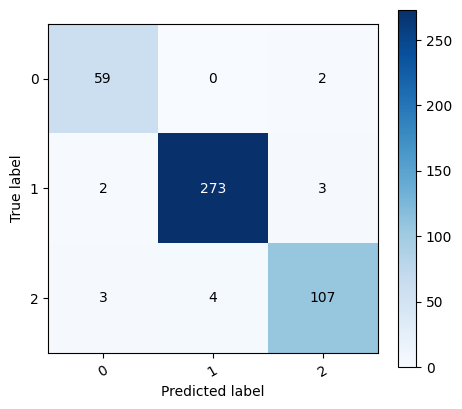


ERROR ANALYSIS
Total errors: 14
Error rate: 3.09%

First 10 errors (index, true_label, pred_label):
  Index 105: True=2, Pred=1
  Index 127: True=1, Pred=0
  Index 139: True=2, Pred=0
  Index 157: True=2, Pred=0
  Index 172: True=1, Pred=2
  Index 177: True=2, Pred=1
  Index 183: True=1, Pred=0
  Index 212: True=2, Pred=0
  Index 373: True=1, Pred=2
  Index 404: True=0, Pred=2

SUMMARY - LoRA r={LORA_R}
Method: LoRA Fine-tuning
Model: roberta-base
LoRA r: 16, alpha: 32, dropout: 0.1
Trainable params: 3,247,107 (2.54%)
Training time: 22.9s
Peak VRAM: 2266 MiB

ABLATION STUDY: Testing different LoRA r values

Training with r=4...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/tmp/pbs.2192.cbis-pbs/ipykernel_2542169/2941140925.py:230: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.366300,0.149702,0.967033,0.954587
2,0.164000,0.073070,0.978022,0.979001
3,0.029700,0.071571,0.989011,0.989643



Training with r=8...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/tmp/pbs.2192.cbis-pbs/ipykernel_2542169/2941140925.py:230: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.386900,0.154099,0.961538,0.952505
2,0.128500,0.078320,0.972527,0.968373
3,0.023500,0.068309,0.989011,0.984180



Training with r=16...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/tmp/pbs.2192.cbis-pbs/ipykernel_2542169/2941140925.py:230: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.496200,0.339192,0.818681,0.554467
2,0.149200,0.057657,0.983516,0.984359
3,0.035200,0.059031,0.994505,0.994856



Training with r=32...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/tmp/pbs.2192.cbis-pbs/ipykernel_2542169/2941140925.py:230: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.377100,0.199586,0.934066,0.911328
2,0.141200,0.071469,0.983516,0.979179
3,0.035100,0.084614,0.983516,0.979179



ABLATION RESULTS
 r  trainable_params  trainable_pct  dev_accuracy   dev_f1  test_accuracy  test_f1  wall_time_sec  peak_vram_mib
 4           1256451       0.997941      0.989011 0.989643        0.97351 0.963018      22.927825           2236
 8           1920003       1.516974      0.989011 0.984180        0.97351 0.965250      23.171749           2246
16           3247107       2.538884      0.994505 0.994856        0.97351 0.964547      23.149690           2267
32           5901315       4.520374      0.983516 0.979179        0.97351 0.963304      23.838228           2305


In [2]:
import time, random, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Configuration
AGREE_SPLIT = "sentences_allagree"
PARQUET_PATH = f"hf://datasets/takala/financial_phrasebank@refs/convert/parquet/{AGREE_SPLIT}/train/*.parquet"

MODEL_NAME = "roberta-base"
SEED = 42
EPOCHS = 3
BATCH_SIZE = 16
LR_LORA = 2e-4  # Higher LR for LoRA
MAX_LEN = 256
WARMUP_RATIO = 0.06
WEIGHT_DECAY = 0.01

# LoRA settings
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Load and split dataset
raw = load_dataset("parquet", data_files={"train": PARQUET_PATH})
dataset_split = raw["train"].train_test_split(test_size=0.2, seed=SEED, stratify_by_column="label")
tmp = dataset_split["train"].train_test_split(test_size=0.1, seed=SEED, stratify_by_column="label")
train_ds, valid_ds, test_ds = tmp["train"], tmp["test"], dataset_split["test"]

print("\nData sizes:")
print(f"  Train: {len(train_ds)}")
print(f"  Valid: {len(valid_ds)}")
print(f"  Test:  {len(test_ds)}")

# Tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_function(batch):
    return tokenizer(batch["sentence"], truncation=True, max_length=MAX_LEN)

train_tok = train_ds.map(tokenize_function, batched=True).rename_column("label", "labels")
valid_tok = valid_ds.map(tokenize_function, batched=True).rename_column("label", "labels")
test_tok = test_ds.map(tokenize_function, batched=True).rename_column("label", "labels")

keep = ["input_ids", "attention_mask", "labels"]
for ds in (train_tok, valid_tok, test_tok):
    ds.remove_columns([c for c in ds.column_names if c not in keep])
    ds.set_format(type="torch", columns=keep)

num_labels = int(len(set(train_ds["label"])))
print(f"Number of labels: {num_labels}")

# Build RoBERTa with LoRA
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

target_modules = ["query", "key", "value", "dense"]
lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=target_modules,
)
model = get_peft_model(base_model, lora_cfg)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"\nLoRA parameters:")
print(f"  Trainable: {trainable:,}")
print(f"  Total: {total:,}")
print(f"  Trainable %: {100.0 * trainable / total:.2f}%")

collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./lora_runs",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LR_LORA,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to=["none"],
    seed=SEED,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=valid_tok,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

# Track training time and memory
start = time.time()
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
train_output = trainer.train()
wall_time_sec = time.time() - start
peak_mem = int(torch.cuda.max_memory_allocated() / 1024**2) if torch.cuda.is_available() else None
print(f"\nTraining time: {wall_time_sec:.1f}s")
if peak_mem:
    print(f"Peak VRAM: {peak_mem} MiB")

# Evaluation
dev_metrics = trainer.evaluate(valid_tok)
pred = trainer.predict(test_tok)
y_true = np.array(test_ds["label"])
y_pred = np.argmax(pred.predictions, axis=-1)

acc = accuracy_score(y_true, y_pred)
f1m = f1_score(y_true, y_pred, average="macro")

print("\n" + "="*60)
print("VALIDATION RESULTS")
print("="*60)
print(f"Accuracy:  {dev_metrics.get('eval_accuracy', 0.0):.4f}")
print(f"Macro-F1:  {dev_metrics.get('eval_f1_macro', 0.0):.4f}")
print(f"Loss:      {dev_metrics.get('eval_loss', 0.0):.4f}")

print("\n" + "="*60)
print("TEST RESULTS")
print("="*60)
print(f"Accuracy:  {acc:.4f}")
print(f"Macro-F1:  {f1m:.4f}")

print("\nClassification Report (TEST):")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
labels_order = sorted(list(set(y_true.tolist())))
cm = confusion_matrix(y_true, y_pred, labels=labels_order)

fig, ax = plt.subplots(figsize=(4.8, 4.2))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
    xticklabels=labels_order, yticklabels=labels_order,
    ylabel="True label", xlabel="Predicted label",
)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")
thr = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"), ha="center", va="center",
                color="white" if cm[i, j] > thr else "black")
fig.tight_layout()
plt.show()

# Error analysis
errors = [(i, int(gt), int(pred)) for i, (gt, pred) in enumerate(zip(y_true, y_pred)) if int(gt) != int(pred)]

print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)
print(f"Total errors: {len(errors)}")
print(f"Error rate: {100.0 * len(errors) / len(y_true):.2f}%")
print(f"\nFirst 10 errors (index, true_label, pred_label):")
for idx, gt, pred in errors[:10]:
    print(f"  Index {idx}: True={gt}, Pred={pred}")

print("\n" + "="*60)
print("SUMMARY - LoRA r={LORA_R}")
print("="*60)
print(f"Method: LoRA Fine-tuning")
print(f"Model: {MODEL_NAME}")
print(f"LoRA r: {LORA_R}, alpha: {LORA_ALPHA}, dropout: {LORA_DROPOUT}")
print(f"Trainable params: {trainable:,} ({100.0 * trainable / total:.2f}%)")
print(f"Training time: {wall_time_sec:.1f}s")
if peak_mem:
    print(f"Peak VRAM: {peak_mem} MiB")
print("="*60)

# Ablation study: test different r values
DO_ABLATION = True

if DO_ABLATION:
    print("\n" + "="*60)
    print("ABLATION STUDY: Testing different LoRA r values")
    print("="*60)
    
    rows = []
    for r in [4, 8, 16, 32]:
        print(f"\nTraining with r={r}...")
        
        base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
        lora_cfg = LoraConfig(
            task_type=TaskType.SEQ_CLS, r=r, lora_alpha=LORA_ALPHA,
            lora_dropout=LORA_DROPOUT, target_modules=target_modules
        )
        model = get_peft_model(base_model, lora_cfg)

        trn = sum(p.numel() for p in model.parameters() if p.requires_grad)
        tot = sum(p.numel() for p in model.parameters())
        
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_tok,
            eval_dataset=valid_tok,
            tokenizer=tokenizer,
            data_collator=collator,
            compute_metrics=compute_metrics,
        )
        
        start = time.time()
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
        trainer.train()
        wall = time.time() - start
        peak = int(torch.cuda.max_memory_allocated() / 1024**2) if torch.cuda.is_available() else None

        dev_m = trainer.evaluate(valid_tok)
        pred = trainer.predict(test_tok)
        y_pred = np.argmax(pred.predictions, axis=-1)
        acc = accuracy_score(y_true, y_pred)
        f1m = f1_score(y_true, y_pred, average="macro")

        rows.append({
            "r": r,
            "trainable_params": trn,
            "trainable_pct": 100.0 * trn / tot,
            "dev_accuracy": dev_m.get("eval_accuracy", 0.0),
            "dev_f1": dev_m.get("eval_f1_macro", 0.0),
            "test_accuracy": acc,
            "test_f1": f1m,
            "wall_time_sec": wall,
            "peak_vram_mib": peak,
        })

    df = pd.DataFrame(rows).sort_values("r").reset_index(drop=True)
    
    print("\n" + "="*60)
    print("ABLATION RESULTS")
    print("="*60)
    print(df.to_string(index=False))
    print("="*60)